In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
import os
import statistics
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

Using TensorFlow backend.


In [2]:
benign_path = '/home/sdsra/Downloads/CTU-Dataset/benign'
benign_datas = pd.DataFrame()
sub_dir_list = os.listdir(benign_path)
for dir in sub_dir_list:
    tmp_data = pd.read_pickle(benign_path + '/' + dir + '/datas-by-origin-tool.pkl')
    benign_datas = pd.concat([benign_datas, tmp_data], ignore_index=True)

In [3]:
malware_path = '/home/sdsra/Downloads/CTU-Dataset/malware-2' 
malware_datas = pd.DataFrame()
for dir in os.listdir(malware_path) :
    pkl_path = malware_path +'/'+dir+'/datas-by-origin-tool.pkl'
    if os.path.exists(pkl_path):
        tmp_data = pd.read_pickle(pkl_path)
        malware_datas = pd.concat([malware_datas, tmp_data], ignore_index=True)

In [4]:
benign_datas['label'].value_counts()

benign    12971
Name: label, dtype: int64

In [5]:
sns.pairplot(dataset, hue='Class')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12971 entries, 0 to 12970
Data columns (total 33 columns):
amount_diff_cert                12971 non-null int64
avg_of_cert_length              12971 non-null float64
avg_of_duration                 12971 non-null float64
avg_of_public_key               12971 non-null float64
avg_periodicity                 12971 non-null float64
dst_ip                          12971 non-null object
dst_port                        12971 non-null object
get_SNI_equal_Dst_IP            12971 non-null int64
inbound_pckts                   12971 non-null int64
is_CNs_in_SNA_dns               12971 non-null int64
is_SNIs_in_SNA_dns              12971 non-null int64
is_valid_cert                   12971 non-null int64
number_of_cert_path             12971 non-null float64
number_of_domains               12971 non-null float64
number_of_flows                 12971 non-null int64
outbound_pckts                  12971 non-null int64
percent_of_established_stats 

In [6]:
malware_datas['label'].value_counts()

botnet    71409
benign        3
Name: label, dtype: int64

In [7]:
malware_datas = malware_datas[malware_datas['label'] == 'botnet']

In [8]:
len(malware_datas)

71409

In [9]:
numeric_columns = list(filter(lambda x: x not in ['src_ip','src_port','dst_ip','dst_port','proto', 'label'], benign_datas.columns))

# Data preprocessing 

In [10]:
X_train, X_test = train_test_split(benign_datas, test_size=0.2, random_state = 101)

In [11]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled  = scaler.transform(X_test[numeric_columns])

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
# autoencoder 1(6 hidden, tanh)
# input_layer = Input(shape=(28,))
# encoder = Dense(20, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(14, activation='tanh')(encoder)
# encoder = Dense(8, activation='tanh')(encoder)
# decoder = Dense(14, activation='tanh')(encoder)
# decoder = Dense(20, activation='tanh')(decoder)
# decoder = Dense(28, activation='tanh')(decoder)

# autoencoder 2(4 hidden, relu)
# input_layer = Input(shape=(28,))
# encoder = Dense(20, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(14, activation='relu')(encoder)
# decoder = Dense(20, activation='relu')(encoder)
# decoder = Dense(28, activation='sigmoid')(decoder)



# autoencoder 3(10 hidden, relu)
# input_layer = Input(shape=(28,))
# encoder = Dense(23, activation='relu')(input_layer)
# encoder = Dense(18, activation='relu')(encoder)
# encoder = Dense(15, activation='relu')(encoder)
# encoder = Dense(10, activation='relu')(encoder)
# encoder = Dense(6, activation='relu')(encoder)
# decoder = Dense(10, activation='relu')(encoder)
# decoder = Dense(15, activation='relu')(decoder)
# decoder = Dense(18, activation='relu')(decoder)
# decoder = Dense(23, activation='relu')(decoder)
# decoder = Dense(28, activation='sigmoid')(decoder)

# autoencoder 3(2 hidden, relu)
input_layer = Input(shape=(28,))
encoder = Dense(10, activation='relu')(input_layer)
decoder = Dense(28, activation='sigmoid')(encoder)







autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                290       
_________________________________________________________________
dense_2 (Dense)              (None, 28)                308       
Total params: 598
Trainable params: 598
Non-trainable params: 0
_________________________________________________________________


In [13]:
nb_epoch = 100
batch_size = 50
adam = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=adam, loss='mse')

history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1
                        )

Train on 9338 samples, validate on 1038 samples
Epoch 1/100
9338/9338 [==============================] - 1s 72us/step - loss: 0.0596 - val_loss: 0.0083
Epoch 2/100
9338/9338 [==============================] - 0s 25us/step - loss: 0.0075 - val_loss: 0.0069
Epoch 3/100
9338/9338 [==============================] - 0s 25us/step - loss: 0.0060 - val_loss: 0.0049
Epoch 4/100
9338/9338 [==============================] - 0s 27us/step - loss: 0.0045 - val_loss: 0.0039
Epoch 5/100
9338/9338 [==============================] - 0s 27us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/100
9338/9338 [==============================] - 0s 33us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 7/100
9338/9338 [==============================] - 0s 33us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/100
9338/9338 [==============================] - 0s 36us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/100
9338/9338 [==============================] - 0s 33us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 10/100
933

9338/9338 [==============================] - 0s 26us/step - loss: 5.1432e-04 - val_loss: 5.5041e-04
Epoch 76/100
9338/9338 [==============================] - 0s 30us/step - loss: 5.1144e-04 - val_loss: 5.4670e-04
Epoch 77/100
9338/9338 [==============================] - 0s 34us/step - loss: 5.1037e-04 - val_loss: 5.5526e-04
Epoch 78/100
9338/9338 [==============================] - 0s 19us/step - loss: 5.0814e-04 - val_loss: 5.4843e-04
Epoch 79/100
9338/9338 [==============================] - 0s 22us/step - loss: 5.0637e-04 - val_loss: 5.4272e-04
Epoch 80/100
9338/9338 [==============================] - 0s 25us/step - loss: 5.0306e-04 - val_loss: 5.4778e-04
Epoch 81/100
9338/9338 [==============================] - 0s 30us/step - loss: 4.9976e-04 - val_loss: 5.3722e-04
Epoch 82/100
9338/9338 [==============================] - 0s 35us/step - loss: 4.9900e-04 - val_loss: 5.3888e-04
Epoch 83/100
9338/9338 [==============================] - 0s 34us/step - loss: 4.9575e-04 - val_loss: 5.3721e

In [14]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
X_test['mse'] = mse

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
X_test['mse']

954      0.000146
741      0.000365
4728     0.000320
8211     0.001287
5918     0.000208
8769     0.000159
6356     0.000198
4500     0.000141
6811     0.000075
9625     0.000103
6670     0.000200
7793     0.000129
2335     0.000032
1240     0.000132
4881     0.000087
2953     0.000068
4027     0.000435
1780     0.001778
12199    0.001481
6261     0.000197
3527     0.000128
6607     0.000195
10261    0.000117
5270     0.001037
10823    0.000141
7506     0.000173
3961     0.000150
9571     0.000351
7869     0.000165
6068     0.000177
           ...   
5371     0.000347
12783    0.000222
6556     0.000143
5113     0.000701
8858     0.000062
344      0.000469
3304     0.000485
12626    0.000259
1546     0.000102
2884     0.000177
10425    0.000140
4402     0.000063
8423     0.000072
12657    0.000142
11293    0.000223
1034     0.000136
2944     0.000142
1843     0.000169
1080     0.000285
11984    0.000158
3645     0.000135
1552     0.000584
9410     0.000168
5694     0.000131
6748     0

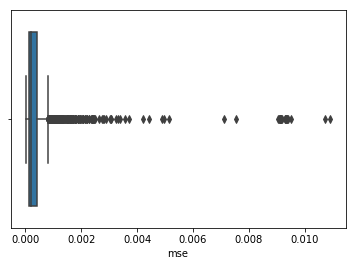

In [16]:
sns.boxplot(X_test['mse'])

In [17]:
malware_scaled  = scaler.transform(malware_datas[numeric_columns])

In [18]:
malware_predictions = autoencoder.predict(malware_scaled)

In [19]:
malware_mse = np.mean(np.power(malware_scaled - malware_predictions, 2), axis=1)
malware_datas['mse'] = malware_mse

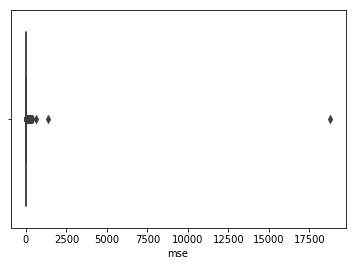

In [20]:
sns.boxplot(malware_datas['mse'])

In [21]:
X_test['is_malware'] = 0

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
malware_datas['is_malware'] = 1

In [23]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2595 entries, 954 to 1942
Data columns (total 35 columns):
amount_diff_cert                2595 non-null int64
avg_of_cert_length              2595 non-null float64
avg_of_duration                 2595 non-null float64
avg_of_public_key               2595 non-null float64
avg_periodicity                 2595 non-null float64
dst_ip                          2595 non-null object
dst_port                        2595 non-null object
get_SNI_equal_Dst_IP            2595 non-null int64
inbound_pckts                   2595 non-null int64
is_CNs_in_SNA_dns               2595 non-null int64
is_SNIs_in_SNA_dns              2595 non-null int64
is_valid_cert                   2595 non-null int64
number_of_cert_path             2595 non-null float64
number_of_domains               2595 non-null float64
number_of_flows                 2595 non-null int64
outbound_pckts                  2595 non-null int64
percent_of_established_stats    2595 non-null

In [24]:
sampled_malware_datas = malware_datas.sample(len(X_test))

In [25]:
compare_data = pd.concat([X_test, sampled_malware_datas], ignore_index=True)
# compare_data = pd.concat([X_test, malware_datas], ignore_index=True)

In [26]:
X_test['mse'].describe()

count    2595.000000
mean        0.000428
std         0.000958
min         0.000021
25%         0.000141
50%         0.000190
75%         0.000407
max         0.010919
Name: mse, dtype: float64

In [27]:
sampled_malware_datas['mse'].describe()

count    2595.000000
mean        0.346905
std         2.325803
min         0.000067
25%         0.000155
50%         0.000237
75%         0.000695
max        55.609620
Name: mse, dtype: float64

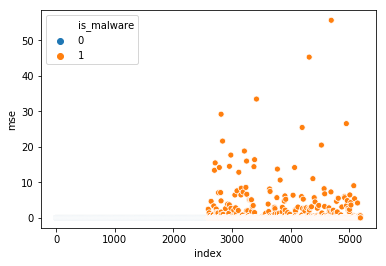

In [28]:
ax = sns.scatterplot(x="index", y="mse", data=compare_data.reset_index(), hue='is_malware')

In [29]:
compare_data.is_malware.value_counts()

1    2595
0    2595
Name: is_malware, dtype: int64

In [30]:
compare_data[compare_data['is_malware'] == 0]

,amount_diff_cert,avg_of_cert_length,avg_of_duration,avg_of_public_key,avg_periodicity,dst_ip,dst_port,get_SNI_equal_Dst_IP,inbound_pckts,is_CNs_in_SNA_dns,is_SNIs_in_SNA_dns,is_valid_cert,number_of_cert_path,number_of_domains,number_of_flows,outbound_pckts,percent_of_established_stats,percent_of_stdev_duration,ratio_of_SNI_ssl,ratio_of_cert,ratio_of_self_signed,ratio_of_size,ratio_of_ssl,ratio_of_tls_version,ratio_of_x509_ssl,src_ip,src_port,stdev_duration,stdev_of_cert_length,stdev_periodicity,total_size_of_flows_orig,total_size_of_flows_resp,label,mse,is_malware
0,1,735.0,36.889028,2048.0,-1.000000,54.236.238.142,tcp,0,32,1,1,2,4.0,2.0,2,28,1.0,0.000000,1.0,-22.584650,0.0,9.037751,0.0,1.000000,1.000000,10.0.2.15,443,28.344093,0.0,-1.000000,1245,11252,benign,0.000146,0
1,1,1100.0,51.048597,2048.0,72.574639,34.196.50.52,tcp,0,130,1,1,5,2.0,4.0,8,124,1.0,0.500000,1.0,-15.577693,0.0,1.367474,0.0,1.000000,0.625000,10.0.2.15,443,44.318469,0.0,49.182273,13454,18398,benign,0.000365,0
2,1,396.0,13.405524,2048.0,1.888369,54.192.93.18,tcp,0,162,1,1,12,4.0,14.0,12,140,1.0,0.166667,1.0,-42.968865,0.0,11.296435,0.0,1.000000,1.000000,10.0.2.15,443,1.819874,0.0,3.775390,6396,72252,benign,0.000320,0
3,1,83.0,303.817747,2048.0,2167.052991,172.217.18.164,tcp,0,381,1,1,4,3.0,1.0,8,283,1.0,0.125000,1.0,-205.721855,0.0,2.560250,0.0,1.000000,0.500000,10.0.2.15,443,119.393660,0.0,2184.683282,38938,99691,benign,0.001287,0
4,1,365.0,52.807707,2048.0,8.903523,23.74.189.100,tcp,0,110,1,1,4,3.0,2.0,4,77,1.0,0.250000,1.0,-47.123723,0.0,10.609831,0.0,1.000000,1.000000,10.0.2.15,443,86.763791,0.0,0.299057,4903,52020,benign,0.000208,0
5,1,371.0,54.922556,2048.0,-1.000000,52.45.225.183,tcp,0,40,1,1,2,3.0,2.0,2,34,1.0,0.000000,1.0,-46.425476,0.0,6.953771,0.0,1.000000,1.000000,10.0.2.15,443,48.711415,0.0,-1.000000,1644,11432,benign,0.000159,0
6,1,366.0,69.645058,2048.0,3.220297,104.98.160.244,tcp,0,378,1,1,10,3.0,1.0,10,250,1.0,0.500000,1.0,-46.458539,0.0,9.918893,0.0,1.000000,1.000000,10.0.2.15,443,63.091833,0.0,4.547644,22575,223919,benign,0.000198,0
7,1,393.0,342.207993,2048.0,-1.000000,74.121.134.216,tcp,0,50,1,1,1,3.0,1.0,1,49,1.0,0.000000,1.0,-42.916709,0.0,0.934508,0.0,1.000000,1.000000,10.0.2.15,443,0.000000,0.0,-1.000000,6184,5779,benign,0.000141,0
8,1,1380.0,40.511994,2048.0,-1.000000,52.54.232.206,tcp,0,29,1,1,2,2.0,2.0,2,29,1.0,0.500000,1.0,-11.867932,0.0,4.510021,0.0,1.000000,1.000000,10.0.2.15,443,33.403708,0.0,-1.000000,1447,6526,benign,0.000075,0
9,1,388.0,78.547445,2048.0,7.609807,72.21.206.135,tcp,0,121,1,1,2,2.0,4.0,6,119,1.0,0.500000,1.0,-44.147160,0.0,0.619149,0.0,1.000000,0.333333,10.0.2.15,443,57.027021,0.0,6.229781,22090,13677,benign,0.000103,0


In [31]:
data_real = compare_data['is_malware']

In [32]:
border_mse = 0.0009

In [33]:
data_predict = compare_data.apply(lambda x: 1 if x['mse'] > border_mse else 0, axis=1)

In [42]:
compare_data['predict'] = data_predict

In [34]:
cm = confusion_matrix(data_real, data_predict)

In [35]:
cm

array([[2402,  193],
       [2025,  570]])

In [36]:
TN, FP, FN, TP = cm.ravel()

In [37]:
accuracy = (TN + TP) / (TN + TP + FP + FN)

In [38]:
precision = TP / (TP + FN)

In [39]:
print('accuracy : {}, precision: {}'.format(accuracy, precision))

accuracy : 0.5726396917148362, precision: 0.21965317919075145


In [43]:
compare_data[compare_data['predict'] == 1].dst_ip.value_counts()

216.58.201.66      3
35.156.247.14      2
62.67.193.85       2
54.192.95.106      2
52.57.223.246      2
93.184.220.70      2
167.80.136.162     2
151.101.112.207    2
35.157.25.10       2
194.153.219.100    2
35.156.76.213      2
198.55.192.56      1
192.0.72.22        1
70.32.81.197       1
78.47.193.133      1
185.33.222.16      1
87.230.62.69       1
106.14.192.168     1
217.160.0.137      1
162.13.154.94      1
104.20.65.160      1
89.16.166.142      1
216.239.32.27      1
77.88.192.248      1
131.247.182.145    1
197.248.210.150    1
216.58.201.14      1
52.27.187.95       1
104.24.119.139     1
137.229.115.76     1
                  ..
207.245.165.171    1
35.185.194.16      1
46.37.160.47       1
46.105.144.243     1
195.42.120.213     1
68.65.120.173      1
151.101.113.133    1
185.119.173.27     1
45.63.29.152       1
104.96.94.203      1
66.179.20.126      1
109.237.140.8      1
139.162.77.248     1
104.199.116.72     1
152.163.66.134     1
23.111.11.222      1
104.24.120.90